In [1]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

/p/software/juwels/stages/2020/software/Jupyter/2021.3.2-gcccoremkl-10.3.0-2021.2.0-Python-3.8.5/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
import pandas as pd

In [3]:
raw_data = '/p/project/hai_cons_ee/data/ai4eo-hyperspectral/raw_data/train_data/'
os.listdir(raw_data)

['train_data', 'wavelengths.csv', 'train_gt.csv']

## CSV files

### Wavelengths

Dataframe connecting hyperspectral image band number and wavelength

In [4]:
df_wavelengths = pd.read_csv(os.path.join(raw_data, 'wavelengths.csv'))

In [5]:
df_wavelengths

,band_no,wavelength
0,1,462.08
1,2,465.27
2,3,468.47
3,4,471.67
4,5,474.86
...,...,...
145,146,925.58
146,147,928.78
147,148,931.98
148,149,935.17


## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [6]:
df_train_gt    = pd.read_csv(os.path.join(raw_data, 'train_gt.csv'))
df_train_gt

,sample_index,P,K,Mg,pH
0,0,45.1,188.0,179.0,7.2
1,1,44.8,205.0,188.0,7.0
2,2,44.4,207.0,145.0,6.8
3,3,46.5,204.0,143.0,6.8
4,4,52.0,212.0,167.0,6.7
...,...,...,...,...,...
1727,1727,40.8,133.0,132.0,6.2
1728,1728,42.7,192.0,126.0,6.5
1729,1729,39.4,180.0,122.0,6.5
1730,1730,37.3,162.0,127.0,6.5


## Hyperspectral image data

### Sample image

In [7]:
train_data = os.path.join(raw_data, 'train_data')

In [8]:
img_id = 1570

In [9]:
hsi_path = os.path.join(train_data, f'{img_id}.npz')

In [10]:
band_id = 100
wavelength = df_wavelengths.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)
    
print(arr.shape)

(150, 138, 137)


In [11]:
labels = df_train_gt[df_train_gt['sample_index']==img_id]
labels

,sample_index,P,K,Mg,pH
1570,1570,47.9,165.0,181.0,6.8


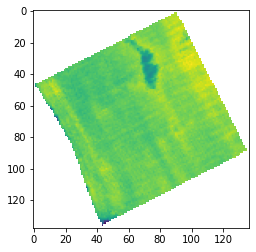

In [12]:
plt.imshow(arr[band_id,:,:])


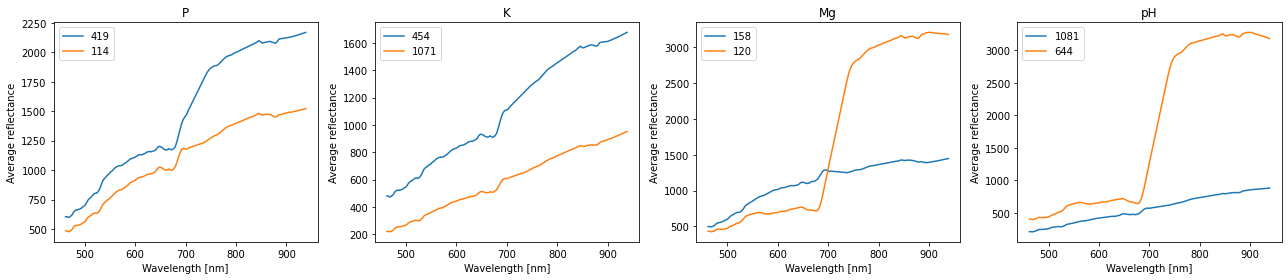

In [13]:
fig, axs = plt.subplots(1, 4, sharex=True, figsize=(18, 4))

for ax, col in zip(axs, df_train_gt.columns[1:]):

    for img_id in [df_train_gt[col].idxmax(), df_train_gt[col].idxmin()]:
        hsi_path = os.path.join(train_data, f'{img_id}.npz')
    
        with np.load(hsi_path) as npz:
            arr = np.ma.MaskedArray(**npz)

        masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
        ax.plot(df_wavelengths['wavelength'], masked_scene_mean_spectral_reflectance, label=img_id)
    ax.legend()
    ax.set_xlabel('Wavelength [nm]')
    ax.set_ylabel('Average reflectance')
    ax.set_title(col)

fig.tight_layout()
plt.show()

In [14]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

### Labels

In [15]:
df_train_gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sample_index  1732 non-null   int64  
 1   P             1732 non-null   float64
 2   K             1732 non-null   float64
 3   Mg            1732 non-null   float64
 4   pH            1732 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 67.8 KB


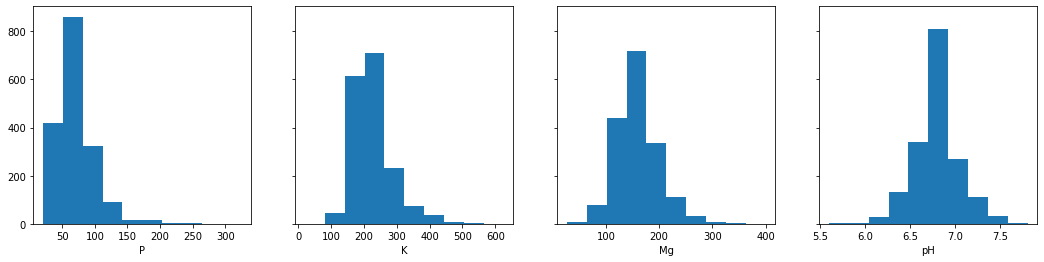

In [16]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(18, 4))

for ax, col in zip(axs, df_train_gt.columns[1:]):

    ax.hist(df_train_gt[col])
    ax.set_xlabel(col)

In [17]:
df_train_gt.drop(columns='sample_index').corr()

,P,K,Mg,pH
P,1.000000,0.413494,-0.103034,0.120067
K,0.413494,1.000000,0.234162,0.168793
Mg,-0.103034,0.234162,1.000000,0.010980
pH,0.120067,0.168793,0.010980,1.000000


### Image dimensions

### Physics

Absorption lines potassium (K):

https://physics.nist.gov/PhysRefData/Handbook/Tables/potassiumtable2.htm

Magnesium (Mg):

https://physics.nist.gov/PhysRefData/Handbook/Tables/magnesiumtable2.htm

Atomic phosphor (P):

https://physics.nist.gov/PhysRefData/Handbook/Tables/phosphorustable2.htm

Diphosphorpentroxid (P2O5 / P4O10):

https://de.wikipedia.org/wiki/Phosphorpentoxid

In [18]:
# from starter notebook

In [19]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


In [20]:
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


X_train = load_data(train_data)
y_train = load_gt(os.path.join(raw_data, "train_gt.csv"))
X_test = load_data("test_data")

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (1732, 150)
Test data shape: (0,)


In [21]:
lambdas = np.tile(df_wavelengths["wavelength"], len(X_train)).reshape((len(X_train), -1))

P
K
Mg
pH


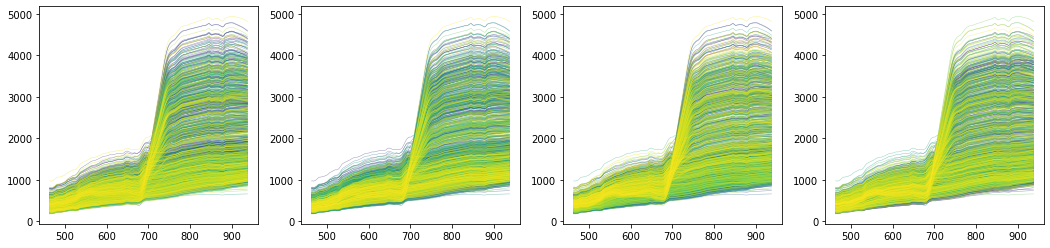

In [22]:
fig, axs = plt.subplots(1, 4, sharex=True, figsize=(18, 4))

for ax, col in zip(axs, df_train_gt.columns[1:]):
    print(col)
    
    ix = np.argsort(df_train_gt[col])
    
    
    multiline(lambdas, X_train[ix], np.arange(len(X_train)), ax=ax, lw=0.5, alpha=0.5)


In [23]:
X_train_delta = X_train - np.mean(X_train, axis=0)

In [24]:
df_combined = df_train_gt.copy()

In [25]:
df_combined['B1'] = X_train_delta[:, 0]
df_combined['B75'] = X_train_delta[:, 74]
df_combined['B150'] = X_train_delta[:, -1]

In [26]:
df_combined.drop(columns='sample_index').corr()

,P,K,Mg,pH,B1,B75,B150
P,1.000000,0.413494,-0.103034,0.120067,-0.027732,-0.061457,-0.028511
K,0.413494,1.000000,0.234162,0.168793,-0.041827,-0.032047,-0.023512
Mg,-0.103034,0.234162,1.000000,0.010980,0.139524,0.175045,0.147930
pH,0.120067,0.168793,0.010980,1.000000,0.151284,0.079933,0.047481
B1,-0.027732,-0.041827,0.139524,0.151284,1.000000,0.891729,0.374650
B75,-0.061457,-0.032047,0.175045,0.079933,0.891729,1.000000,0.689022
B150,-0.028511,-0.023512,0.147930,0.047481,0.374650,0.689022,1.000000


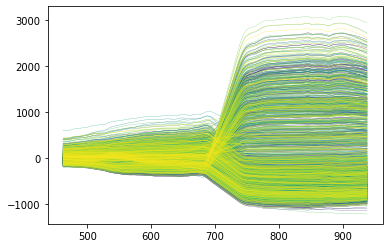

In [27]:
multiline(lambdas, X_train_delta[ix], np.arange(len(X_train)), lw=0.25)